## Assignment 6 - IBM Machine Learning

**Time series analysis of Petrobras stocking prices (Brazilian oil and gas industry)**

Data was download in google sheets api, using the following code: =GOOGLEFINANCE("PETR4"; "all"; "01/01/2000"; "09/06/2022"; "DAILY"). Data was exported into an .csv file named *'petr4_stockingprice.csv'*, and opened into a pandas dataframe.

The dataframe columns corresponds to:
* **0 - Date**: only business days;
* **1 - Open**: opening price;
* **2 - High**: quotation value at the end of day;
* **3 - Low**: lowest daily quote value;
* **4 - Close**: quotation value at the end of day;
* **5 - Volume**: volume of stock quotes.

## 1) Exploratory Data Analysis, Visualization, and Preprocessing

In [1]:
#Import needed modules
import warnings
warnings.filterwarnings('ignore')
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.api import ExponentialSmoothing 

In [2]:
#Importing the dataframe, first look

df = pd.read_csv ('petr4_stockingprice.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,09/05/2006 16:56:00,"23,68","24,12","23,68","23,78",326008992
1,10/05/2006 16:56:00,24,"24,08","23,76","24,08",235028176
2,11/05/2006 16:56:00,"24,1","24,2","23,66","23,98",339910240
3,12/05/2006 16:56:00,"23,33","23,68","23,25","23,68",325767616
4,15/05/2006 16:56:00,"23,25","23,5","22,4","23,45",668024576


In [3]:
df.dtypes # Seeing types

#Wrong type for Date, should be datetime64.
#Also wrong type for variables Open, High, Low, and Close.
#Only Volume has a correct type.

Date      object
Open      object
High      object
Low       object
Close     object
Volume     int64
dtype: object

In [4]:
#Transforming all variables to the correct type;

for element in df.columns:
    if element == 'Date':
        df[element] = pd.to_datetime(df[element], dayfirst=True) # Convert to day time pattern
    elif element == 'Volume': # Does not alter type
        continue
    else: # Converting the string like object to float
        df[element] = df[element].map (lambda x: float (re.sub (',', '.', x)))

In [5]:
# Checking the new types
df.dtypes # Correct types now

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [6]:
#Checking frequency of data

df = df.set_index ('Date') # freq = None -> no frequency atributed to data.
df.index[0:5]

DatetimeIndex(['2006-05-09 16:56:00', '2006-05-10 16:56:00',
               '2006-05-11 16:56:00', '2006-05-12 16:56:00',
               '2006-05-15 16:56:00'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [7]:
#Checking beggining and end of the time series:
'First day: {}; Last day: {}.'.format(df.index.min(), df.index.max())

'First day: 2006-05-09 16:56:00; Last day: 2022-06-08 16:56:00.'

In [8]:
#Checking whether the data is complete. Days are missing.
'Unique days: {}; Total days in this data range: {}.'.format (len(df.index.unique()), (df.index.max()-df.index.min()).days)

'Unique days: 3788; Total days in this data range: 5874.'

In [9]:
new_index = pd.date_range(df.index.min(), df.index.max()) # Completing index
df = df.reindex(new_index, fill_value=None) #Fill missing days with Na values
df.index[0:5] # Now Frequency is correct -> freq = 'D'.

DatetimeIndex(['2006-05-09 16:56:00', '2006-05-10 16:56:00',
               '2006-05-11 16:56:00', '2006-05-12 16:56:00',
               '2006-05-13 16:56:00'],
              dtype='datetime64[ns]', freq='D')

In [10]:
df.head() #NAs are now filling missing days

,Open,High,Low,Close,Volume
2006-05-09 16:56:00,23.68,24.12,23.68,23.78,326008992.0
2006-05-10 16:56:00,24.00,24.08,23.76,24.08,235028176.0
2006-05-11 16:56:00,24.10,24.20,23.66,23.98,339910240.0
2006-05-12 16:56:00,23.33,23.68,23.25,23.68,325767616.0
2006-05-13 16:56:00,NaN,NaN,NaN,NaN,NaN


In [11]:
#Resampling data to week values

df = df.resample('W').mean()
df.index[0:5] # Now Frequency is set to week

DatetimeIndex(['2006-05-14', '2006-05-21', '2006-05-28', '2006-06-04',
               '2006-06-11'],
              dtype='datetime64[ns]', freq='W-SUN')

In [12]:
# Interpolating data to fill NA values.
df = df.interpolate(method='spline', order = 3, axis = 0) # interpolating the data
df.head() # Now all days are filled

,Open,High,Low,Close,Volume
2006-05-14,23.777500,24.020000,23.5875,23.88,3.066788e+08
2006-05-21,23.036667,23.293333,22.3400,23.10,4.348205e+08
2006-05-28,21.697500,22.087500,21.2250,21.48,3.661691e+08
2006-06-04,22.115000,22.312500,21.7700,22.07,3.379538e+08
2006-06-11,21.210000,21.292000,20.3200,21.11,3.114345e+08


### Only Close values will be considered for prediction purposes.

In [13]:
#Descriptive statistics for Close time series

pd.options.display.float_format = '{:.2f}'.format
gen_desc = df.describe().T
gen_desc = gen_desc.drop ('count', axis = 1)
gen_desc.rename (columns = {'50%':'Median',
                           'mean':'Mean',
                           'std':'Standard Deviation',
                           'min':'Minimum',
                           '25%':'Quantile 25',
                           '75%':'Quantile 75',
                           'max':'Maximum'}, inplace = True)

gen_desc['Range'] =  gen_desc['Maximum'] - gen_desc['Minimum']
pd.DataFrame (gen_desc.loc['Close'])

,Close
Mean,22.71
Standard Deviation,8.16
Minimum,4.33
Quantile 25,17.25
Median,22.42
Quantile 75,27.58
Maximum,51.02
Range,46.69


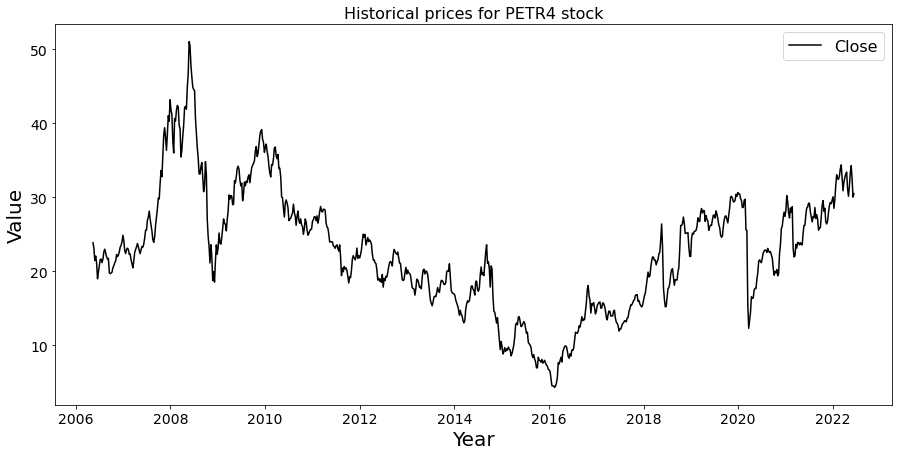

In [14]:
#Seeing the data behavior over time

df = pd.DataFrame (df['Close'], index = df.index)

plt.figure(figsize=(15,7))

plt.plot (df, 'black', label='Close')
plt.legend(fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Historical prices for PETR4 stock', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

#Visually speaking the time series is not stationary. Further statistical
#test is needed to confirm it. 
#The data also appeared to be additive 
#(seazonality+trend+residual), given that the seazonality does not increase
#proportionally with trend.

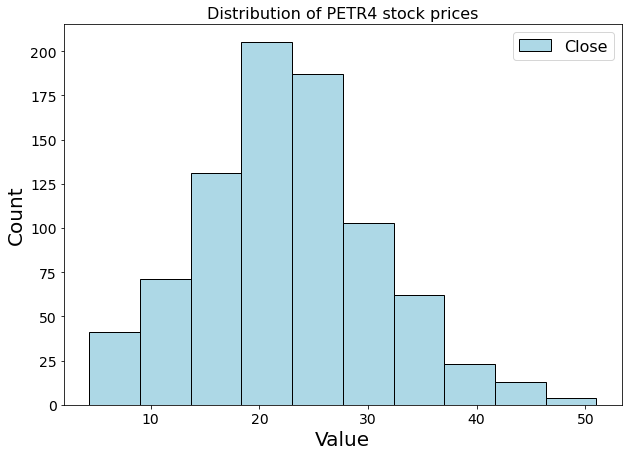

In [15]:
#Plotting histogram
plt.figure(figsize=(10,7))
plt.hist (df, label='Close', linewidth = 1, color = 'lightblue', ec="black")
plt.legend(fontsize=16)
plt.xlabel('Value', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Distribution of PETR4 stock prices', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

#The data appeared to follwos a normal distribution. 
#Further test is needed to confirm. Nonetheless, normally distribution is 
#not required to model time series.

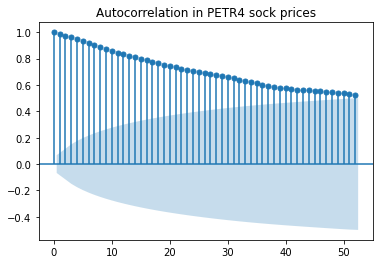

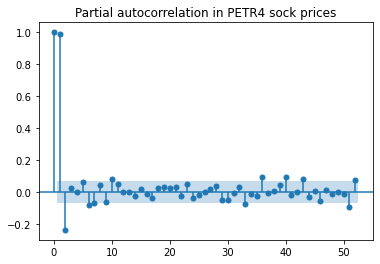

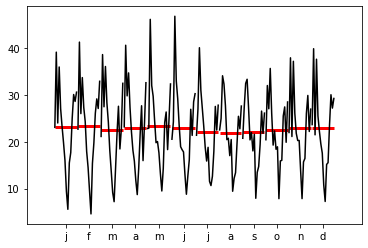

In [16]:
# Investigating the lags of 52 weeks (lags), corresponding to a year;

acf_plot = plot_acf(df['Close'], lags=52, title='Autocorrelation in PETR4 sock prices')
# No autocorrelation decay to zero. The series is probably not stationary.

pacf_plot = plot_pacf(df['Close'], lags=52, title='Partial autocorrelation in PETR4 sock prices')
# The PACF significance decay after a few lags.

month_df = df['Close'].resample("M").mean()
month_plot = month_plot(month_df) 
# Seazonality behavior in the time series analyzed. Apparently a monthly
# seazonality occur. Particularly at the begginning of the month, the stock
# value decreases, and at the end of the month, the stock values increases.

In [17]:
#Since the time series behavior appeared to be additive 
#(increase in trend, does not result in proportional increase in seazonality)
#The time series was decomposed by additive model.
#Moreover, the series appeared to have a monthly seazonality, so period = 4.
decomposition = seasonal_decompose(df, model='additive', period=4)
estimated_trend = decomposition.trend # trend
estimated_seasonal = decomposition.seasonal # seazonality
estimated_residual = decomposition.resid # residuals

#Plotting the dataframe
decomposed_df = pd.DataFrame ([estimated_trend, 
                estimated_seasonal, estimated_residual]).T.fillna(0).head()

decomposed_df

,trend,seasonal,resid
2006-05-14,0.00,0.03,0.00
2006-05-21,0.00,-0.06,0.00
2006-05-28,22.29,-0.04,-0.76
2006-06-04,21.43,0.08,0.57
2006-06-11,20.73,0.03,0.35


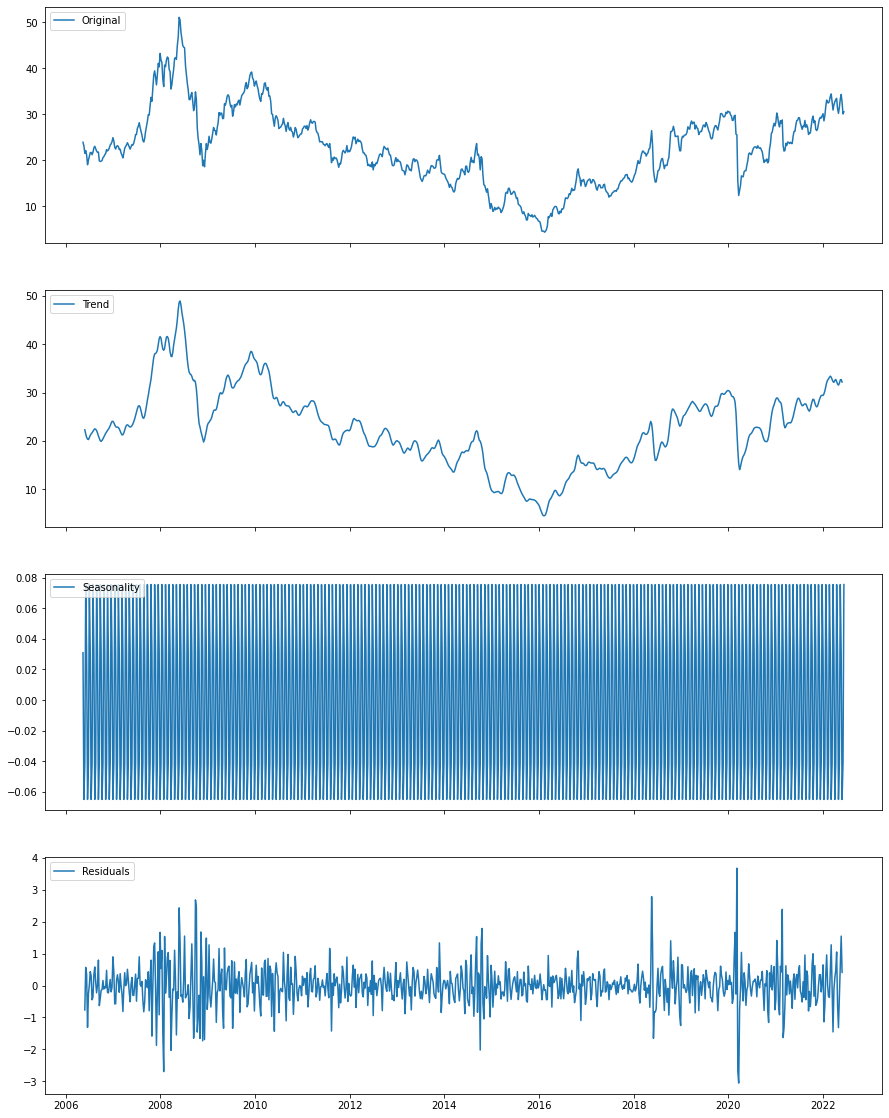

In [18]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(20)
fig.set_figwidth(15)

axes[0].plot(df, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

# The thrend also suggests that the data is not stationary.
# Data also possses seazonality.

In [19]:
adf, pvalue, usedlag, nobs, critical_values, icbest  = adfuller(df)

'ADFtest_score: '+str(adf)+'; pvalue: '+str(pvalue)+'; used_lag: '+str(usedlag)
#pvalue > 0.05, indicating non-stationarity (We can't reject null hyphotesis)
#This result was expected given the trend data presents and also 
#No autocorrelation decay to zero in ACF plot.

'ADFtest_score: -2.2782967092732083; pvalue: 0.17906327613969647; used_lag: 9'

In [20]:
df['lag_4'] = df.shift(4).fillna(0) #Lag 4 differencing to remove seazonality
df['seasonal_diff'] = df['Close'] - df['lag_4']
df.tail(5) #Seeing lag differences

,Close,lag_4,seasonal_diff
2022-05-15,33.25,33.41,-0.16
2022-05-22,34.27,31.18,3.09
2022-05-29,32.52,30.15,2.36
2022-06-05,30.02,31.47,-1.45
2022-06-12,30.49,33.25,-2.76


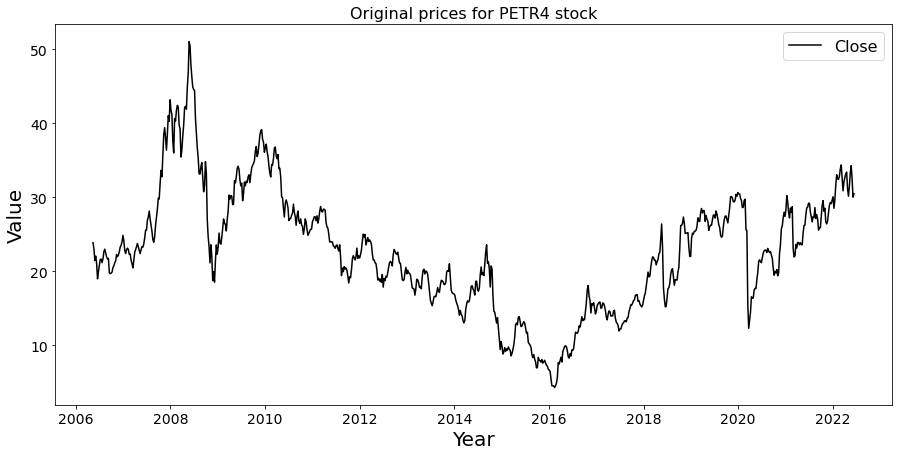

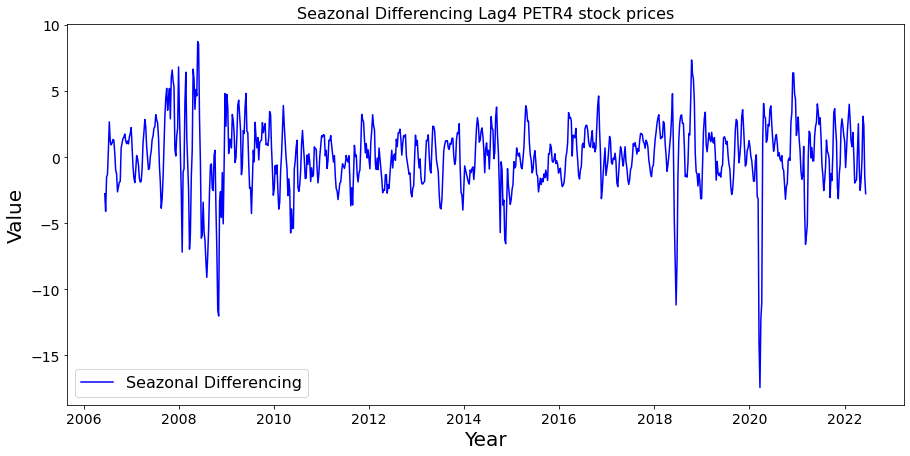

In [21]:
plt.figure(figsize=(15,7))
plt.plot (df['Close'], 'black', label='Close')
plt.legend(fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Original prices for PETR4 stock', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

plt.figure(figsize=(15,7))
plt.plot (df['seasonal_diff'][4:], 'blue', label='Seazonal Differencing')
plt.legend(fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Seazonal Differencing Lag4 PETR4 stock prices', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show() # Except for a small increase in variance between 2006 and 2008,
           # THe diff time series (lag4) appears to be stationary.

In [22]:
#Checking stationarity of differenced time series
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['seasonal_diff'])

print ('diff_pvalue:', pvalue) # ADF test now have pvalue <0.05, indicating
                               # stationarity (reject null hyphotesis) 

diff_pvalue: 2.0353457679200923e-08


### 2) Key EDA findings, data cleaning and preprocessing summary

1- At first, data index was filled to contain daily values. Data was then resampled to week days, using means for such purpose. The final data contains average PETR4 stock prices per week.

2- Visually (line plot), the time series is not stationary, nonetheless, statistical test is needed to confirm it. The data also appeared to be additive(seazonality+trend+residual), given that the seazonality does not increase proportionally with trend.

3- The data appeared to follows a normal distribution (histogram plot). Further test is needed to confirm (not performed). Nonetheless, normally distribution is not required to model time series.

4- The ACF plot suggest that no autocorrelation decay to zero, which further reinforces that time series is probably not stationary. The PACF
significance decay after a few lags. The Month plot suggest seazonality behavior in the time series analyzed, pparently monthly. Particularly at the begginning of the month, the stock prices greatly increase, and at the end of the month, it drastically decreases.

5- Data was decomposed using the additive model, in trend, seazonal, and residuals. Data trend suggest suggests that the data is not stationary, given that it does not follows a plateau paralel to x axis. Seazonal component could also be observed.

6- The ADFuller test presented pvalue > 0.05, indicating non-stationarity (We can't reject null hyphotesis). This result was expected given the trend data presents and also no autocorrelation decay to zero in ACF plot.

7- Data was then diferenced using lag4 to remove seazonal component. The line plot for differenciated data suggested that except for a small increase in variance between years 2006 and 2008 the diff time series appears to be stationary, since it presented constant mean and variance.

8- ADFuller test for the diff data returned a pvalue of <0.05, then we can reject the null hypothesis, indicating stationarity.

### 3) Main Objectives

1 - Build different time series models using AutoArima approach, Exponential smoothing, and LSTM to predict PETR4 stock prices values. 

2 - Check model's performance by analyzing metrics, such as RMSE and MAPE, in order to identify the best model to predict the PETR4 prices.

3 - Check models for overfitting.

### 4) Creating and evaluating models

### a) Auto Arima

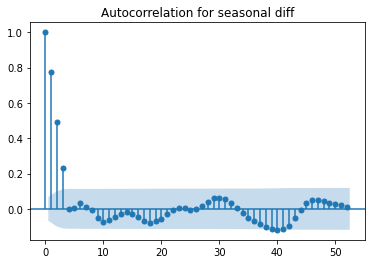

In [23]:
acf_plot = plot_acf(df['seasonal_diff'], lags=52, title='Autocorrelation for seasonal diff')
#Rapidly decrase after 4 lags. Max AutoARIMA parameters set to 4.

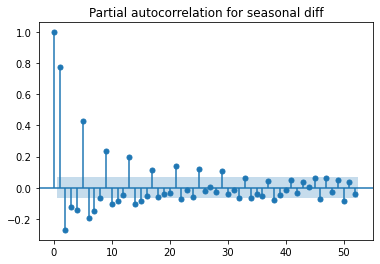

In [24]:
pacf_plot = plot_pacf(df['seasonal_diff'], lags=52, title='Partial autocorrelation for seasonal diff')
#Alterning between positive and negative values. Possibly ARMA model

In [25]:
#Auto arima Seazonal component = 4
autoarima = pm.auto_arima(df['Close'][:788],trace=True, m = 4,
                          start_p=0, max_p = 4, start_q = 0, max_q = 4,
                          start_d=0, max_d = 4, start_P = 0, max_P = 4,
                          start_Q=0, max_Q = 4, start_D = 0, max_D = 4,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
print(autoarima.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2444.190, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2405.112, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=2405.275, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2442.212, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=2406.989, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=2405.295, Time=0.11 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=2404.540, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=2405.466, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=2407.288, Time=0.37 sec
 ARIMA(1,1,0)(1,0,2)[4] intercept   : AIC=2407.389, Time=0.40 sec
 ARIMA(1,1,0)(0,0,2)[4] intercept   : AIC=2405.397, Time=0.14 sec
 ARIMA(1,1,0)(2,0,2)[4] intercept   : AIC=2408.368, Time=0.43 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=2444.646, Time=0.19 sec
 ARIMA(2,1,0)(1,0,1)[4] intercept   : AIC=2405.755, Time=0.33 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept

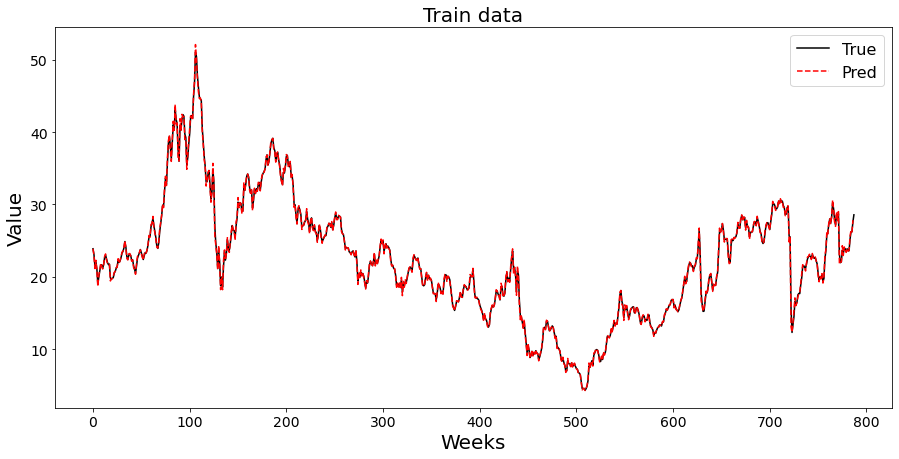

In [26]:
#Ploting y_true and y_pred values
plt.figure(figsize=(15,7))
plt.plot (list (df['Close'][:-52]), 'black', label='True')
plt.plot (autoarima.predict_in_sample()[1:], 'r--', label='Pred')
plt.legend(fontsize=16)
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Train data', fontsize=20)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()
#Model performs well in Train data. But it appeared to overfit.

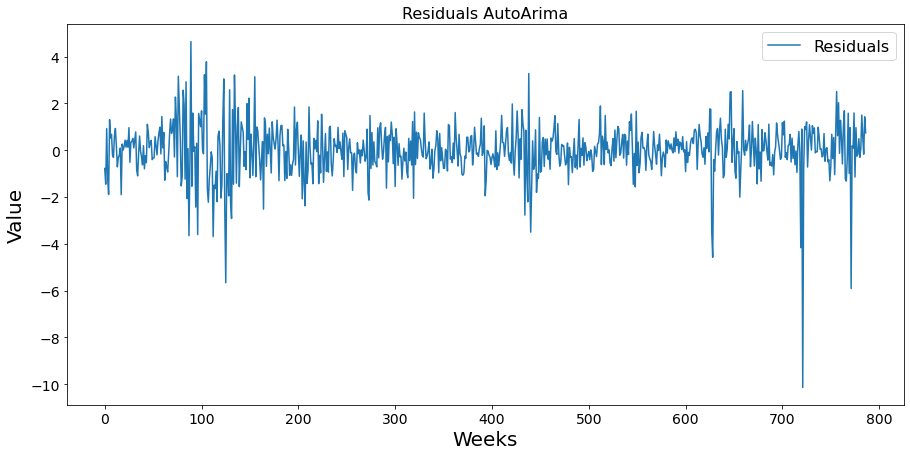

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  788
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood               -1197.075
Date:                           Sun, 12 Jun 2022   AIC                           2402.149
Time:                                   18:29:39   BIC                           2420.822
Sample:                                        0   HQIC                          2409.328
                                           - 788                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2315      0.027      8.685      0.000       0.179       0.284
ar.S.L4       -0.7533      0.145     -5.186      0.000      -1.038      -0.469
ma.S.L4        0.6945      0.161      4.320      0.000       0.379       1.010
sigma2         1.2264      0.025     48.756      0.000       1.177       1.276
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              4665.10
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -1.38
Prob(H) (two-sided):                  0.05   Kurtosis:                        14.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
#Plotting residuals
plt.figure(figsize=(15,7))
plt.plot (autoarima.resid()[1:], label='Residuals')
plt.legend(fontsize=16)
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Residuals AutoArima', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

autoarima.summary() #Seeing stat summary for Model in train data

#1 - Jarque-Bera: pvalue = 0.00 (reject null hypothesis) 
#   R: non-normally distributed residuals -> Not desired.
#2 - Ljung-Box: pvalue = 0.88 (do not reject null hypothesis)
#   R: No serial correlation in residuals
#3 - Heteroskedasticity: pvalue = 0.05 (borderline to reject null hypothesis)
#   R: Homocedasticity

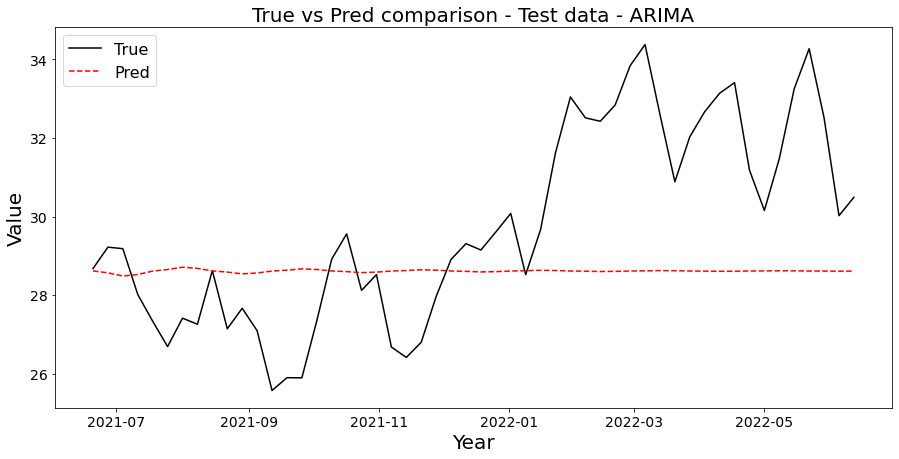

In [28]:
#Predicting the last year value using ARIMA model
y_pred = autoarima.predict(n_periods = 52, return_conf_int = True)[0] 

df['AutoArima_pred'] =  np.concatenate([pd.DataFrame(df.Close[0:-52]), pd.DataFrame(y_pred)])

#Ploting y_true and y_pred values
plt.figure(figsize=(15,7))
plt.plot (df['Close'][-52:], 'black', label='True')
plt.plot (df['AutoArima_pred'][-52:], 'r--', label='Pred')
plt.legend(fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('True vs Pred comparison - Test data - ARIMA', fontsize=20)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()# model performed poorly on test data, further suggesting overfitting.

In [29]:
def mape (y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return str(round(mape, 2))+'%'

def model_evaluation(y_true, y_pred):
    mse_value = round(mse(y_true, y_pred),2)
    mae_value = round(mae(y_true, y_pred),2)
    mape_value = mape(y_true, y_pred)
    rmse_value = round(rmse (y_true, y_pred),2)
    dataframe = pd.DataFrame(data = [rmse_value, mse_value, mae_value, mape_value], 
                             index =['rmse','mse','mae','mape'], columns = ['test_metrics'])
    return dataframe

y_true = df['Close'][-52:]

#Plotting model evaluation
autoarima_test = model_evaluation(y_true, y_pred).T
autoarima_test

,rmse,mse,mae,mape
test_metrics,2.71,7.34,2.17,7.07%


### b) Holt-Winter

In [30]:
#Triple Sponential Smoothing model
holt_winter = ExponentialSmoothing(df['Close'][:-52],
                                   trend="additive",
                                   seasonal="additive",
                                   seasonal_periods=4).fit(optimized=True)

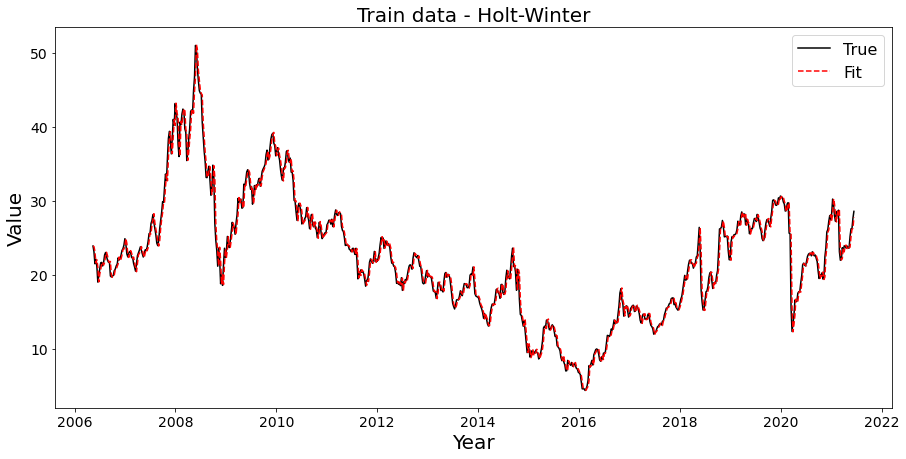

In [31]:
#Plotting Train data vs fitted values 
plt.figure(figsize=(15,7))
plt.plot (df['Close'][:-52], 'black', label='True')
plt.plot (holt_winter.fittedvalues, 'r--', label='Fit')
plt.legend(fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Train data - Holt-Winter', fontsize=20)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()
#Model performs well in Train data. But it appeared to overfit.

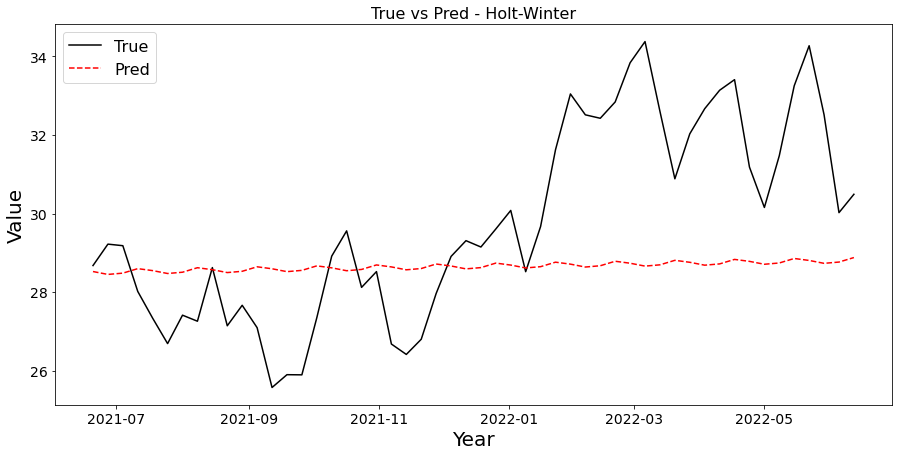

In [32]:
#Predicting the last year value using Holt-Winter model
holt_winter_pred = holt_winter.forecast(52)

plt.figure(figsize=(15,7))
plt.plot (df['Close'][-52:], 'black', label='True')
plt.plot (holt_winter_pred, 'r--', label='Pred')
plt.legend(fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('True vs Pred - Holt-Winter', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show() #Bad prediction for Holt-Winter either. Model appears to overfit

In [33]:
y_true = df['Close'][-52:]
y_pred = holt_winter_pred
residuals = holt_winter.resid

#Plotting model evaluation
model_evaluation(y_true, y_pred).T

,rmse,mse,mae,mape
test_metrics,2.63,6.90,2.11,6.85%


### C) Deep Learning

In [71]:
#Window size to 4.
def keras_format (series, size):
    #Convert original train array into a keras-like array
    prov_list = []
    series = list (series)
    
    for i in range (len(series)-(size-1)):
        prov_list.append (series[i:i+size])
    prov_array = np.array(prov_list)

    return prov_array.reshape(prov_array.shape[0], prov_array.shape[1], 1)

def get_train_y (train, test, size):
    #Determine train y array
    prov_list=[]
    for i in range(size, len(train)+1):
        if i < len(train):
            prov_list.append(train[i])
        else:
            prov_list.append(test[i-len(train)])
            
    return np.array(prov_list)

train = list (df['Close'][:-52])
test = list (df['Close'][-52:])

size = 52 # A year size (52 weeks)
train_X = keras_format (train, size)
train_y = get_train_y(train, test, size)

print('Training input shape:', train_X.shape)
print('Training output shape:', train_y.shape)

Training input shape: (737, 52, 1)
Training output shape: (737,)


In [90]:
#LSTM Model with 70 cell units
model = Sequential()  

model.add(LSTM(70, input_shape=(train_X.shape[1],1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(train_X, train_y, epochs=80, batch_size=64, verbose=1) # Fit into data

Epoch 1/80
12/12 [==============================] - 0s 6ms/step - loss: 509.0297
Epoch 2/80
12/12 [==============================] - 0s 5ms/step - loss: 437.4172
Epoch 3/80
12/12 [==============================] - 0s 5ms/step - loss: 378.2087
Epoch 4/80
12/12 [==============================] - 0s 5ms/step - loss: 323.4973
Epoch 5/80
12/12 [==============================] - 0s 5ms/step - loss: 271.5994
Epoch 6/80
12/12 [==============================] - 0s 5ms/step - loss: 230.3341
Epoch 7/80
12/12 [==============================] - 0s 5ms/step - loss: 199.3936
Epoch 8/80
12/12 [==============================] - 0s 5ms/step - loss: 175.9595
Epoch 9/80
12/12 [==============================] - 0s 5ms/step - loss: 158.6613
Epoch 10/80
12/12 [==============================] - 0s 5ms/step - loss: 145.5270
Epoch 11/80
12/12 [==============================] - 0s 5ms/step - loss: 134.2287
Epoch 12/80
12/12 [==============================] - 0s 5ms/step - loss: 124.1323
Epoch 13/80
12/12 [======

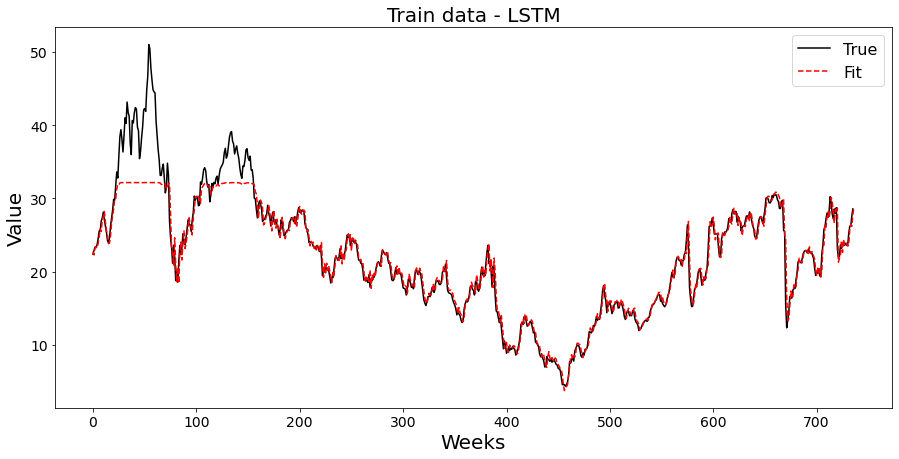

In [91]:
X_train_pred = list (model.predict(train_X).reshape (train_X.shape[0]))

#Plotting Train data vs fitted values 
plt.figure(figsize=(15,7))
plt.plot (list(df['Close'][size:-52]), 'black', label='True')
plt.plot (X_train_pred, 'r--', label='Fit')
plt.legend(fontsize=16)
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Train data - LSTM', fontsize=20)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()
#Model performs well in Train data. And does not appeared to overfit.

In [92]:
X_init = train_X[-1]
pred_time = 52

def dl_predict (X_init, model, pred_time):
    size = X_init.shape[0]
    y_pred = []
    
    prov_array = X_init.reshape (1, size, 1)
    y_pred.append (float (model.predict (prov_array)))
    
    for i in range (pred_time-1):
        prov_array = list (prov_array.reshape (size))[1:]
        prov_array.append (y_pred[i])
        prov_array = np.array (prov_array)
        prov_array = prov_array.reshape (1, size, 1)
        y_pred.append (float (model.predict (prov_array)))
    return y_pred

y_pred = dl_predict (X_init, model, pred_time)

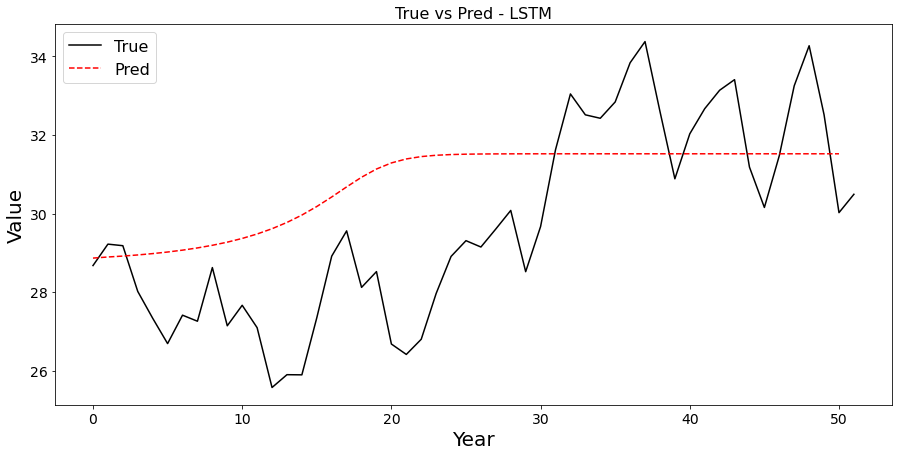

In [93]:
#Predicting the last year value using LSTM model
plt.figure(figsize=(15,7))
plt.plot (list (df['Close'][-52:]), 'black', label='True')
plt.plot (y_pred[1:], 'r--', label='Pred')
plt.legend(fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('True vs Pred - LSTM', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show() #The model could predict data tendency better than ARIMA and ExpSmooth

In [94]:
y_true = df['Close'][-52:]

#Plotting model evaluation
model_evaluation(y_true, y_pred).T # Best metrics achieved

,rmse,mse,mae,mape
test_metrics,2.19,4.82,1.85,6.42%


## 5) Results

### A) Best Model

The best model was LSTM, since among the three forecast models tried, LSTM presented the lowest error metrics (RMSE, MSE, MAE, and MAPE) when predicting the test data. Moreover, this model does not overfit in train data, and could also correctly predict test data trend.

### B) Main Findings

1- Despite all models presented similar error metrics, LSTM model was the only one to correctly predict test data trend, and was also the only model to does not overfit in train data.

2- The analyzed residuals from AutoArima are non-normally distributed, but they do not present serial correlation and are also homocedastic, which is desired for the model. 

3- The LSTM model performed well on test data, with low error metrics. The model MAPE error was less than 7%, so it provided an accurate prediction on PETR4 stock price. The model also follows y test data trend, with similar errors magnitude overtime, which may help future decision making for investors in PETR4.

### C) Model's limitation and perspectives

* **Limitations:**

    1- Despite being a good model given the metrics analyzed, it still make  wrong predictions with approximately 7% error, given the MAPE value.

    2- Furthermore, LSTM model could have been benefit from more train epochs (or not). Plotting validation and Train error could have been performed during LSTM train to provide a notion on which number of epochs is ideal.
    
    3- No crossvalidation, and grid search were performed for training the models, which could have benefit their performance.


* **Perspectives:**

    1- Perform a grid search with crossvalidation for different LSTM or RNN hyperparameters. Plotting validation and Train error during LSTM train to provide a good notion on the ideal number of epochs to train the model.
    
    2- Instead of use AUTOARIMA approach, perform a manual selection of ARIMA parameters.
    
    3- Perform other time-series models for forecast the data, such as Facebook Prophet method.
    
    4- Instead of using week data, select a daily or month frequence for data, and use it to train and validate the models.